
---

# Predicting Chaos: Machine Learning Classifications of Duffing Oscillator Behaviors

**Author:** Ryan Hardig  
**Course:** Physics 5300, Autumn 2025  
**Date:** December 2025

---

## The Big Three Questions 
### The What
- In a chaotic equation, given a set of parameters, can we predict whether or not this solution is periodic or chaotic?
### The Why
- Mapping chaotic regions is computationally expensive, so finding a way to predict these features could be a faster, more efficient solution.
- "Predicting Chaos" sounds cool! 
### The How
- We will construct an artificial dataset of chaotic solutions and use machine learning techniques to predict its chaotic nature.

## The Duffing Equation
### $\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$
- The Duffing equation is a relatively simple, well-studied chaotic equation 
- We've already seen how to make solutions for this equation, so why not expand on it?
- Parameters: $\delta$ (damping), $\alpha$ (linear stiffness), $\eta$ (cubic stiffness/nonlinearity), $\gamma$ (forcing amplitude), $\omega$ (forcing frequency).


## Process: Numerical Solver (snippet)
From `duffing/solver.py`:
```python
def duffing_rhs(t, y, delta, alpha, beta, gamma, omega):
    x, v = y
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return [dxdt, dvdt]

def solve_duffing(t_span, y0, params, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 5000)
    sol = solve_ivp(duffing_rhs, t_span, y0, t_eval=t_eval,
                    args=(params['delta'], params['alpha'], params['beta'],
                          params['gamma'], params['omega']),
                    rtol=1e-9, atol=1e-12)
    return sol
```
We integrate long enough to capture asymptotic behavior before feature extraction.

## Process: Features and Labels (snippet)
From `duffing/features.py`:
```python
def estimate_lyapunov_benettin(params: dict,
                               transient_cycles: int = 50,
                               measure_cycles: int = 100,
                               eps: float = 1e-8,
                               dt_cycles: int = 1) -> float:
    """Estimate the largest Lyapunov exponent using the Benettin algorithm.

    Args:
        params: dict with keys delta, alpha, beta, gamma, omega
        transient_cycles: number of driving cycles to discard before measurement
        measure_cycles: number of driving cycles over which to measure growth
        eps: initial separation magnitude in x (perturbation applied to x only)
        dt_cycles: renormalization interval in number of driving cycles (usually 1)

    Returns:
        Approximate largest Lyapunov exponent (float, 1/time units used by params)

```

- Labels: periodic/chaotic from Lyapunov sign.

## Process: Dataset Generation (snippet)
From `duffing/generate_data.py`:
```python
def generate_dataset(n_param_sets: int, out_csv: str, rng_seed: int = 0,
                     compute_lyapunov: bool = False, run_minutes: float = 0.0):
    """Generate a dataset by sampling parameters randomly.

    Args:
        n_param_sets: number of random base parameter sets to draw (ignored if run_minutes>0).
        out_csv: output CSV path.
        rng_seed: RNG seed for reproducibility.
        compute_lyapunov: whether to compute LLE for each sample (slow).
        run_minutes: if >0, run the generator for approximately this many minutes
                     instead of a fixed number of param sets.

    Returns:
        pandas.DataFrame saved to out_csv
    """
```
- Each sample: random parameters, solve, extract features, compute Lyapunov, label as periodic/chaotic.

In [6]:

import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

from duffing.generate_data import generate_dataset
df = generate_dataset(n_param_sets=3, out_csv='demo_small.csv', rng_seed=1, compute_lyapunov=True)
df.shape
df.head()

param sets: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


,delta,alpha,beta,omega,gamma,x_mean,x_rms,x_max,x_min,x_std,dom_freq,label_gamma,lyapunov,periodic,base_id
0,0.056064,1.801855,0.630655,1.917839,1.627974,0.001256,1.614111,3.072289,-3.147252,1.614111,0.304939,1.627974,-0.023927,True,0
1,0.048099,1.310810,1.054719,1.279350,0.235040,-0.003102,0.603257,1.139729,-1.145426,0.603249,0.204959,0.235040,-0.023787,True,1
2,0.077816,0.152573,0.927571,1.661486,1.585655,-0.001563,1.490826,2.748345,-2.890700,1.490825,0.264947,1.585655,-0.033129,True,2


## Process: Training a Model (snippet)
From `duffing/model.py`:
```python
def train_rf_model(df, target='Periodic'):
    X, y, feature_cols = _prepare_xy(df, target=target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = float(accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ...
    return model, stats
```
- Train/test split, fit Random Forest, evaluate accuracy/confusion matrix.
- Similar for regression: `train_rf_regressor` for Lyapunov prediction.

## Results: Classification (Random Forest)
- Metrics (held-out split):
  - Accuracy: **0.922**
  - Confusion matrix: [[137, 117], [59, 1943]]
  - Precision: **0.943**
  - AUC: **0.952**
- Sample preds (y_true → y_pred): [0→1, 1→1, 0→0, 1→1, 1→1, 1→1, 0→0, 1→1, 1→1, 0→1]
- Interpretation: strong true-positive rate for chaotic cases; some periodic→chaotic false positives remain.
- Use case: fast screening of parameter sets before expensive integration.

Loading model from: ..\rf_model_periodic.joblib
Loading dataset from: ..\data\01122025_dataset.csv
Accuracy: 0.9171
Precision: 0.9307
AUC: 0.9414
Confusion Matrix:
[[ 108  146]
 [  41 1961]]


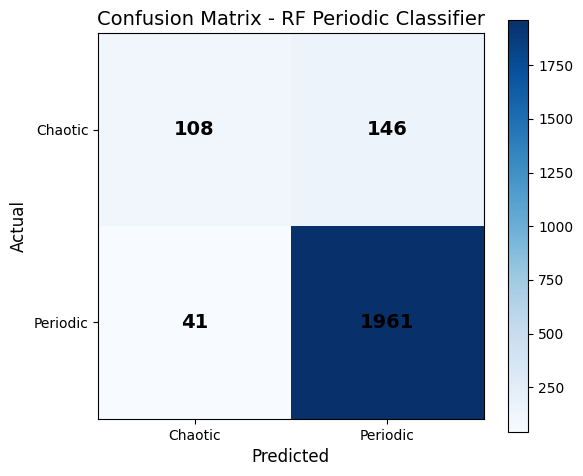

In [8]:
# Load the trained periodic classification model and compute stats
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score
import matplotlib.pyplot as plt
from pathlib import Path

# Load model
model_candidates = [
    Path('rf_model_periodic.joblib'),
    Path('..') / 'rf_model_periodic.joblib',
    Path(proj_root) / 'rf_model_periodic.joblib'
]

model_path = None
for p in model_candidates:
    if p.exists():
        model_path = str(p)
        print(f'Loading model from: {model_path}')
        break

if model_path is None:
    raise FileNotFoundError("Model file 'rf_model_periodic.joblib' not found")

model = joblib.load(model_path)

# Load dataset and compute metrics
csv_candidates = [
    Path('data') / '01122025_dataset.csv',
    Path('..') / 'data' / '01122025_dataset.csv',
    Path(proj_root) / 'data' / '01122025_dataset.csv'
]

csv_path = None
for p in csv_candidates:
    if p.exists():
        csv_path = str(p)
        print(f'Loading dataset from: {csv_path}')
        break

if csv_path is None:
    raise FileNotFoundError("Dataset CSV not found")

df = pd.read_csv(csv_path)

# Prepare features and labels
features = ['alpha', 'beta', 'delta', 'gamma', 'omega']
X = df[features].astype(float)
raw_y = df['periodic']

if pd.api.types.is_bool_dtype(raw_y):
    y = raw_y.astype(int)
elif pd.api.types.is_numeric_dtype(raw_y):
    y = (raw_y != 0).astype(int)
else:
    y_mapped = raw_y.map({True: 1, False: 0, 'True': 1, 'False': 0})
    y = y_mapped.fillna(0).astype(int)

# Use same split as training (test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Predict and compute metrics
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)

# Compute AUC
try:
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
    else:
        auc = None
except Exception:
    auc = None

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'AUC: {auc:.4f}' if auc else 'AUC: N/A')
print('Confusion Matrix:')
print(conf_mat)

# Plot confusion matrix using matplotlib only (no seaborn)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(conf_mat, interpolation='nearest', cmap='Blues')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, conf_mat[i, j],
                      ha="center", va="center", color="black", fontsize=14, fontweight='bold')

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Chaotic', 'Periodic'])
ax.set_yticklabels(['Chaotic', 'Periodic'])
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix - RF Periodic Classifier', fontsize=14)

# Add colorbar
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('confusion_matrix_rf_periodic.png', dpi=150)
plt.show()

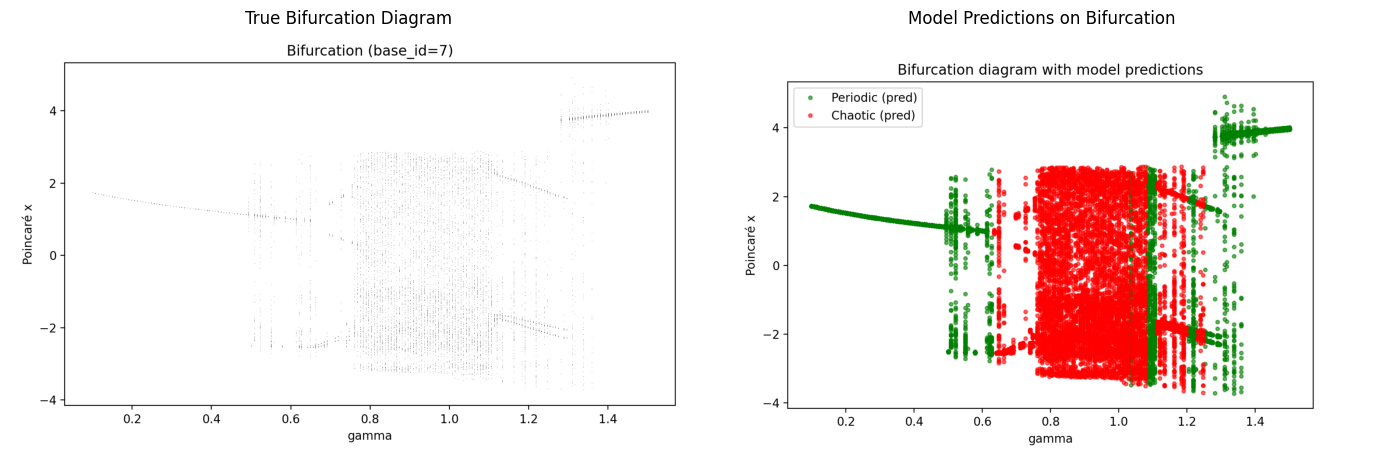

Bifurcation comparison saved


In [ ]:
# Display true bifurcation diagram
from PIL import Image
import os
from pathlib import Path

# Look for true bifurcation diagram
bif_true_candidates = [
    Path('bifurcation_demo.png'),
    Path('..') / 'bifurcation_demo.png',
    Path(proj_root) / 'bifurcation_demo.png'
]

bif_true_path = None
for p in bif_true_candidates:
    if p.exists():
        bif_true_path = str(p)
        break

if bif_true_path:
    fig, ax = plt.subplots(figsize=(8, 5))
    img_true = Image.open(bif_true_path)
    ax.imshow(img_true)
    ax.set_title('True Bifurcation Diagram', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print('True bifurcation diagram displayed')
else:
    print('True bifurcation diagram (bifurcation_demo.png) not found')

## Results: Lyapunov Regression (Random Forest Regressor)
- Metrics (same split):
  - MSE: **0.00257**
  - R²: **0.607** (captures a majority of variance)
- First 10 (true → pred):
  - 0.04998 → 0.01674
  - -0.13478 → -0.13481
  - 0.06877 → 0.03653
  - -0.02988 → -0.02985
  - -0.00417 → 0.00290
  - -0.06030 → -0.05939
  - 0.14677 → 0.11761
  - -0.04986 → -0.04970
  - -0.08580 → -0.07834
  - 0.03004 → 0.00253
- Interpretation: captures sign and scale reasonably; still underestimates extremes—room for deeper models or more data.

## Discussion & Next Steps
- Value: Predict chaos quickly to skip costly integrations in parameter sweeps.
- Extensions: 
  - Predict divergence rate/time-to-diverge from initial conditions.
  - Broaden to other chaotic systems (Lorenz, Rössler) using same pipeline.
  - Improve labeling fidelity with longer integrations or variational methods.
  - Calibrate class thresholds or use cost-sensitive training to cut false positives.
- Takeaway: ML surrogates can accelerate exploration while retaining good accuracy on chaotic/periodic classification.